# This an example of a simple spherical harmonic analysis (SHA) for convex closed objects
## We only use radial expansion and reconstruction here
## Mahmoud Shaqfa

Prerequests of this file:
pip3 install numpy-stl, vtk, scipy

In [20]:
import time, copy, os, sys, vtk, scipy, math
from pprint import pprint
from stl import mesh
import numpy as np
np.set_printoptions(threshold=np.inf)
from scipy.special import sph_harm
from scipy import special
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import matplotlib.tri as tri
plt.style.use('tableau-colorblind10')
plt.rcParams['text.usetex'] = True
from IPython.display import set_matplotlib_formats
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from matplotlib import cm, colors
from matplotlib.colors import LightSource
#set_matplotlib_formats('pdf') # For vectorized output of the figures

# External files
sys.path.append(r'./codes')
from render_stl import *
from stl_info import *

## Simple spherical parameterization of closed convex objects
Simply put, the parameterization process maps closed objects onto a unit sphere centered at the origin $(x=0, y=0, z=0)$. The described method here only works for convex objects. For non-convex objects it requires some toplogical transformations (not included here). We first strart by importing the file and then we make sure that the coordinates of the vertices are all centered around the origin x, y, z = (0,0,0). This will allow us to compute the spherical coordinates (we only need $\theta$ and $\phi$) as the size of the mapped sphere doens't matter here.

This parametrization process will be used for associating every value in the input signal $r$ with $\theta$ (Azimuthal angle) and $\phi$ (Elevation angle) in radians $r(\theta, \phi)$.

The number of faces is: 11264, with 5634 vertices.


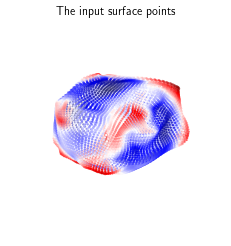

In [21]:
filename = 'input_geometries/Stone.stl';
loaded_object = STLAnalyzer(filename)
v = loaded_object.vertices
v = v - np.mean(v, axis=0) # Normalize for finding the coordinates

# Coordinates transformation from Cartesian to Spherical and vice versa
def sph2cart(theta, phi, r=1):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cart2sph(x, y, z):
    phi = np.arctan2(y, x); neg_id = np.where(phi < 0); phi[neg_id] += 2*math.pi
    theta = np.arctan2(z, (np.sqrt(x**2 + y**2))); theta = math.pi/2 - theta
    r = np.sqrt(x**2+y**2+z**2)
    return theta, phi, r

def plot_3D_pc(x, y, z, maps=None, title_txt=''):
    # plot 3D point cloud
    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(111, projection='3d')
    fmax, fmin = maps.max(), maps.min()
    fcolors = (maps - fmin)/(fmax - fmin)
    _scatter = ax.scatter(x, y, z, marker=".", linewidth=0.05, facecolor=cm.seismic(fcolors))
    plt.axis('off')
    plt.title(title_txt)
    plt.show()

thetas, phis, rs = cart2sph(v[:,0], v[:,1], v[:,2])
plot_3D_pc(v[:,0], v[:,1], v[:,2], rs, 'The input surface points')

## Constructing the spherical harmonics basis functions

$$Y^m_n (\theta, \phi) = \sqrt{\frac{2n+1}{4\pi}\frac{(n-|m|)!}{(n+|m|)!}}~P^m_n(\cos \theta)~e^{im\phi}$$,
valid $\forall$ $m \leq n$ and $n \geq 0$.

$$Y^{-m}_n (\theta, \phi) = (-1)^{|m|}~Y^{*|m|}_n (\theta, \phi)$$,
valid $\forall$ $|m| $ and $m~<~0$. Where $Y^{*|m|}_n$ is the complex conjugate $Y^{|m|}_n$.



## Spherical Harmonics Expansion
### Using the Ordinary-Least-Square OLS fitting algorithm

$$\hat{f}(\theta, \phi) = \sum_{l=0}^{L_{max}} \sum_{m=-l}^{l} \hat{a}^{m}_{l} Y^{m}_{l}(\theta, \phi) \approx f(\theta, \phi)$$

$$
\begin{bmatrix}
y_{1,1} & y_{1,2} & y_{1,3} & \dots & y_{1,k}\\ 
y_{2,1} & y_{2,2} & y_{2,3} & \dots & y_{2,k}\\ 
\vdots & \vdots & \vdots & \ddots & \vdots\\ 
y_{n,1} & y_{n,2} & y_{n,3} & \dots & y_{2,k}\\ 
\end{bmatrix}
\begin{bmatrix}
x_1\\ 
x_2\\ 
\vdots\\
x_k
\end{bmatrix}
=
\begin{bmatrix}
f_1\\ 
f_2\\ 
\vdots\\
f_k
\end{bmatrix}
$$

Where, $$y_{i,j} = Y^m_l(\theta_i, \phi_i), j = l^2 + l + m + 1, and~ k = (L_{max} + 1 )^2$$

$$f_k = x(\theta_k, \phi_k),~ y(\theta_k, \phi_k),~ or~ z(\theta_k, \phi_k). \text{ (The spherical functions)}$$ 


Note: the orthonormality of this system works as far as $n_{vert} >> L_{max}$

And $0 \leq i <  n_{vert}$


References:

https://en.wikipedia.org/wiki/Spherical_harmonics

Python3.-: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html (Note the flipped $\theta$ and $\phi$ definitions)



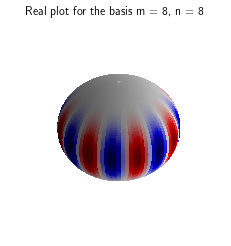

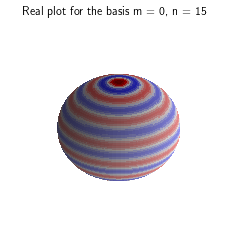

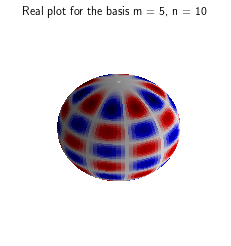

In [22]:
def plot_sph_mn(m, n, subdivgrid=50):
    # ref: https://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/
    theta = np.linspace(0, np.pi, subdivgrid)
    phi = np.linspace(0, 2*np.pi, subdivgrid)
    phi, theta = np.meshgrid(phi, theta)
    x, y, z = sph2cart(theta, phi)
    fcolors = scipy.special.sph_harm(m, n, phi, theta).real
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)
    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors),
                   linewidth=0, antialiased=False, alpha=1.0)
    ax.set_axis_off()
    plt.title('Real plot for the basis m = {}, n = {}'.format(str(m), str(n)))
    plt.show()

plot_sph_mn(8,8,100)
plot_sph_mn(0,15,100)
plot_sph_mn(5,10,100)

In [23]:
def basis_functions(max_n, thetas, phis):
    # This function can be optimized and further vectorized, but for readability I leave it like this :)
    Y_mat = np.zeros([thetas.shape[0], (max_n+1)**2], dtype=complex)
    for n in range(max_n + 1):
        for m in range(-n, n+1):
            if m >= 0:
                Y_mat[:, n**2 + n + m] = scipy.special.sph_harm(abs(m), n, phis, thetas)
            else:
                Y_mat[:, n**2 + n + m] = ((-1)**m) * scipy.special.sph_harm(abs(m), n, phis, thetas).conj()
    return Y_mat

Y_mat = basis_functions(20, thetas, phis)

The solution of the coefficients can be estimated by OLS:
$$ \vec{X} = \big([Y]^T [Y]\big)^{-1} [Y]^T \vec{F}$$

In [24]:
coefs = (np.linalg.inv(np.transpose(Y_mat).dot(Y_mat)).dot(np.transpose(Y_mat))).dot(rs)

## Shape Descriptors
### Rotation-, position, size-invariants

#### Rotation-invariant shape descriptors ($d_l$) is the energy stored in every degree $l$:

$$d_l = \sum_{i \in {x, y, z}}{\sum_{m=-l}^{m=l}{\lVert C_{i,l}^{m} \lVert}} = \sum_{i \in {x, y, z}}{\sum_{m=-l}^{m=l}{C_{i,l}^{m} C_{i,l}^{m*}}}$$

#### Scale-invariant descriptors $D_l$:

$$D_l = \frac{d_l}{\sum_{i = 1}^{l_{max}}{d_i}}$$

#### Position-invariant:

$$C_{x, 0}^{0} = C_{y, 0}^{0} = C_{z, 0}^{0} := 0.0$$

##### Reference: B. D. ZHAO, D. H. WEI and J. F. WANG Particle shape quantification using rotation-invariant spherical harmonic analysis

Text(0.5, 1.0, '$Shape~descriptors~of~r(\\theta, \\phi)$')

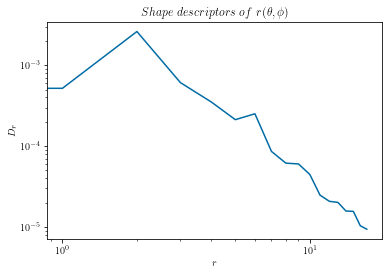

In [25]:
def shape_descriptors(coefs, max_n):
    Dr = np.zeros((max_n,))
    # Rotation-invariant
    for n in range(max_n):
        for m in range(-n, n+1):
            Dr[n] += coefs[n**2 + n + m].real**2 + coefs[n**2 + n + m].imag**2
    # Scale-invariant
    Dr /= Dr[0]
    return Dr

Dr = shape_descriptors(coefs, max_n=20)

plt.figure()
plt.loglog(np.arange(len(Dr)-2), (Dr[2::]))
plt.ylabel(r'$D_r$')
plt.xlabel(r'$r$')
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$')

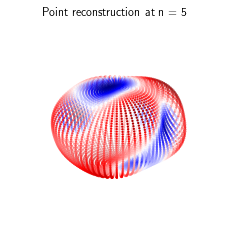

In [26]:
def basis_reconstruction(coefs, rec_thetas, rec_phis, max_n):
    # also can be vectorized :)
    rec_Y_mat = basis_functions(max_n, rec_thetas, rec_phis)
    rec_rs = np.zeros(rec_thetas.shape, dtype=complex)
    for n in range(0, max_n+1):
        for m in range(-n, n+1):
            rec_rs += coefs[n**2 + n + m] * rec_Y_mat[:, n**2 + n + m]    
    return rec_rs.real

rec_max_n=5
subdivgrid=70
rec_thetas, rec_phis = np.linspace(0, math.pi, subdivgrid), np.linspace(0, 2*math.pi, subdivgrid)
grid_thetas, grid_phis = np.meshgrid(rec_thetas, rec_phis)
_angles = np.column_stack((grid_thetas.ravel(), grid_phis.ravel()))
rec_rs = basis_reconstruction(coefs, _angles[:,0], _angles[:,1], rec_max_n)
rec_x, rec_y, rec_z = sph2cart(_angles[:,0], _angles[:,1], rec_rs)
plot_3D_pc(rec_x, rec_y, rec_z, rec_rs, 'Point reconstruction at n = {}'.format(str(rec_max_n)))

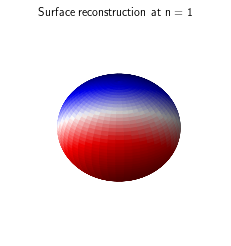

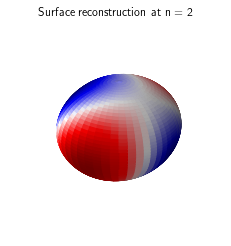

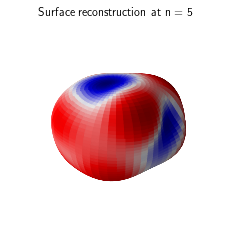

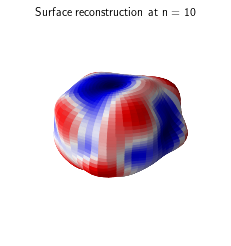

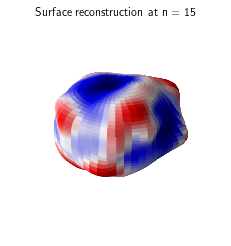

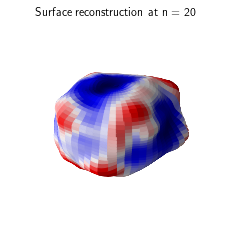

In [27]:
def math_basis_functions(max_n, thetas, phis):
    # This function can be optimized and further vectorized, but for readability I leave it like this :)
    Y_mat = np.zeros([thetas.shape[0], thetas.shape[1], (max_n+1)**2], dtype=complex)
    for n in range(max_n + 1):
        for m in range(-n, n+1):
            if m >= 0:
                Y_mat[:, :, n**2 + n + m] = scipy.special.sph_harm(abs(m), n, phis, thetas)
            else:
                Y_mat[:, :, n**2 + n + m] = ((-1)**m) * scipy.special.sph_harm(abs(m), n, phis, thetas).conj()
    return Y_mat

def math_basis_reconstruction(coefs, rec_thetas, rec_phis, max_n):
    rec_Y_mat = math_basis_functions(max_n, rec_thetas, rec_phis)
    rec_rs = np.zeros(rec_thetas.shape, dtype=complex)
    for n in range(0, max_n+1):
        for m in range(-n, n+1):
            rec_rs += coefs[n**2 + n + m] * rec_Y_mat[:, :, n**2 + n + m]    
    return rec_rs.real

def plot_math_rec(rec_max_n, coefs, subdivgrid):
    for max_n in rec_max_n:
        rec_thetas, rec_phis = np.linspace(0, math.pi, subdivgrid), np.linspace(0, 2*math.pi, subdivgrid)
        grid_thetas, grid_phis = np.meshgrid(rec_thetas, rec_phis)
        rec_rs = math_basis_reconstruction(coefs, grid_thetas, grid_phis, max_n)
        rec_x, rec_y, rec_z = sph2cart(grid_thetas, grid_phis, rec_rs)
        fmax, fmin = rec_rs.max(), rec_rs.min()
        fcolors = (rec_rs - fmin)/(fmax - fmin)
        fig = plt.figure(figsize=plt.figaspect(1.))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(rec_x, rec_y, rec_z, facecolors=cm.seismic(fcolors))
        plt.title('Surface reconstruction at n = {}'.format(str(max_n)))
        plt.axis('off')
        plt.show()

plot_math_rec(rec_max_n=[1,2,5,10,15,20], coefs=coefs, subdivgrid=150)

Your mesh is not closed, the mass methods will not function
            correctly on this mesh.  For more info:
            https://github.com/WoLpH/numpy-stl/issues/69


The number of faces is: 2854, with 1463 vertices.


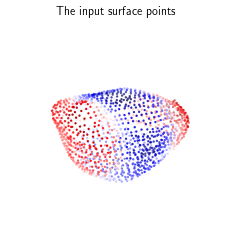

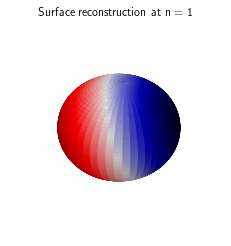

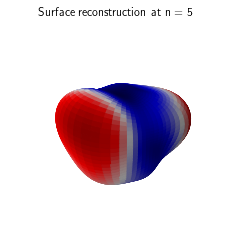

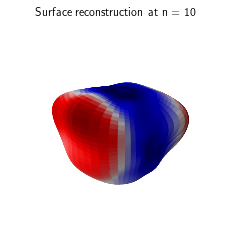

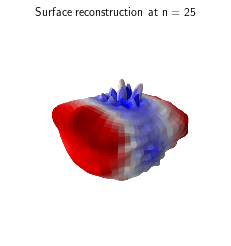

In [28]:
# Examples 1 for Ignat
max_n = 25
filename = 'input_geometries/iphone_lidar.stl';
loaded_object = STLAnalyzer(filename)
v = loaded_object.vertices
v = v - np.mean(v, axis=0) # Normalize for finding the coordinates
thetas, phis, rs = cart2sph(v[:,0], v[:,1], v[:,2])
plot_3D_pc(v[:,0], v[:,1], v[:,2], rs, 'The input surface points')
Y_mat = basis_functions(max_n, thetas, phis)
coefs1 = (np.linalg.inv(np.transpose(Y_mat).dot(Y_mat)).dot(np.transpose(Y_mat))).dot(rs)
Dr1 = shape_descriptors(coefs1, max_n)
plot_math_rec(rec_max_n=[1,5,10,25], coefs=coefs1, subdivgrid=150)

# plot_math_rec(rec_max_n=[1,2,5,10,15,20], coefs=coefs1, subdivgrid=150)

Your mesh is not closed, the mass methods will not function
            correctly on this mesh.  For more info:
            https://github.com/WoLpH/numpy-stl/issues/69


The number of faces is: 54670, with 28802 vertices.


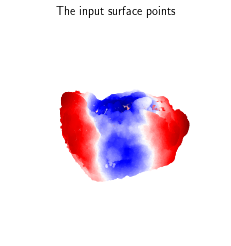

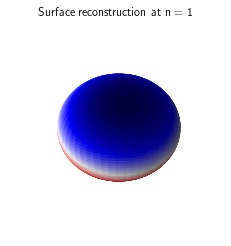

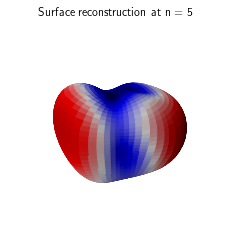

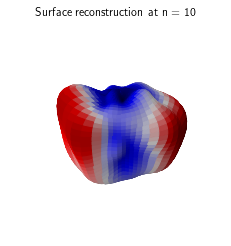

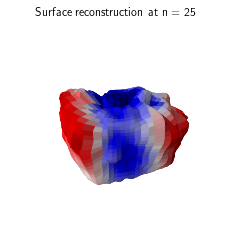

In [29]:
# Examples 2 for Ignat
max_n = 25
filename = 'input_geometries/scanner.stl';
loaded_object = STLAnalyzer(filename)
v = loaded_object.vertices
v = v - np.mean(v, axis=0) # Normalize for finding the coordinates
thetas, phis, rs = cart2sph(v[:,0], v[:,1], v[:,2])
plot_3D_pc(v[:,0], v[:,1], v[:,2], rs, 'The input surface points')
Y_mat = basis_functions(max_n, thetas, phis)
coefs2 = (np.linalg.inv(np.transpose(Y_mat).dot(Y_mat)).dot(np.transpose(Y_mat))).dot(rs)
Dr2 = shape_descriptors(coefs2, max_n)
plot_math_rec(rec_max_n=[1,5,10,25], coefs=coefs2, subdivgrid=150)

Your mesh is not closed, the mass methods will not function
            correctly on this mesh.  For more info:
            https://github.com/WoLpH/numpy-stl/issues/69


The number of faces is: 72643, with 36499 vertices.


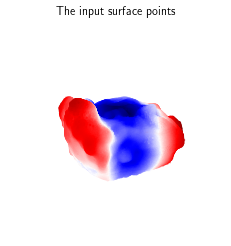

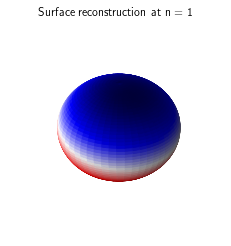

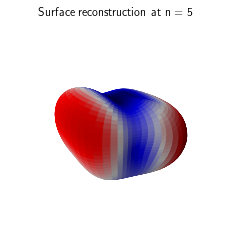

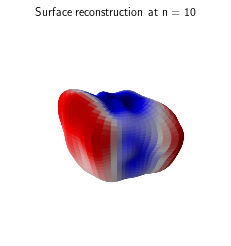

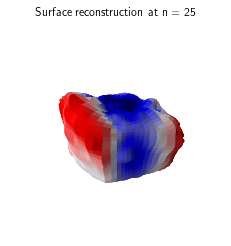

In [30]:
# Examples for Ignat
max_n = 25
filename = 'input_geometries/iphone_truedepth.stl';
loaded_object = STLAnalyzer(filename)
v = loaded_object.vertices
v = v - np.mean(v, axis=0) # Normalize for finding the coordinates
thetas, phis, rs = cart2sph(v[:,0], v[:,1], v[:,2])
plot_3D_pc(v[:,0], v[:,1], v[:,2], rs, 'The input surface points')
Y_mat = basis_functions(max_n, thetas, phis)
coefs3 = (np.linalg.inv(np.transpose(Y_mat).dot(Y_mat)).dot(np.transpose(Y_mat))).dot(rs)
Dr3 = shape_descriptors(coefs3, max_n)
plot_math_rec(rec_max_n=[1,5,10,25], coefs=coefs3, subdivgrid=150)

[1.00000000e+00 3.33950697e-03 3.32378367e-02 3.41442740e-03
 1.05822082e-03 1.22085061e-03 1.73484775e-04 4.16893402e-04
 2.92806055e-05 1.63842816e-04 6.55431182e-05 7.63337750e-05
 9.87335241e-05 6.43719261e-05 1.21846326e-04 7.76941016e-05
 1.60459721e-04 1.62498520e-04 1.47457102e-04 1.80769914e-04
 1.03387997e-04 1.68022537e-04 7.67031835e-05 1.15576457e-04
 9.06839109e-05]
[1.00000000e+00 4.31659754e-03 5.55263487e-02 2.34815901e-03
 3.66380834e-03 9.44924570e-04 8.46630374e-04 1.01821202e-03
 4.08067155e-04 4.10330131e-04 3.25996982e-04 2.24234021e-04
 1.60442626e-04 1.38648353e-04 1.43289907e-04 1.11570941e-04
 1.09067737e-04 6.42974569e-05 1.08930720e-04 9.63316582e-05
 6.38922117e-05 5.62246606e-05 4.72053922e-05 6.07524337e-05
 5.40443144e-05]
[1.00000000e+00 4.71370053e-03 5.30828590e-02 2.17132369e-03
 3.45885565e-03 1.06944523e-03 8.30660007e-04 9.04079026e-04
 3.89416711e-04 3.49732710e-04 2.73814759e-04 2.23215877e-04
 1.13199781e-04 1.32114539e-04 1.16567368e-04 6.146

Text(0.5, 1.0, '$Shape~descriptors~of~r(\\theta, \\phi)$')

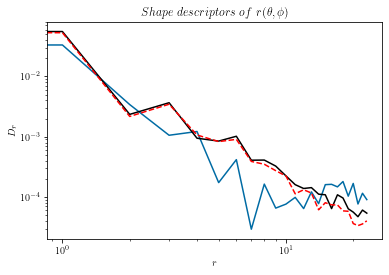

In [32]:
plt.figure()
plt.loglog(np.arange(len(Dr1)-1), (Dr1[1::]))
plt.loglog(np.arange(len(Dr2)-1), (Dr2[1::]), 'k-')
plt.loglog(np.arange(len(Dr3)-1), (Dr3[1::]), 'r--')
print(Dr1)
print(Dr2)
print(Dr3)
plt.ylabel(r'$D_r$')
plt.xlabel(r'$r$')
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$')